## Setup

In [1]:
import torch
from torch import tensor
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

In general we're going to be faced with a dataset with an unknown and probably nonlinear relationship. But for now let's use a simple dataset with a known linear relationship:

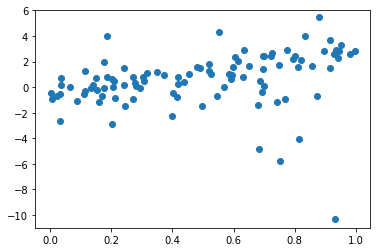

In [2]:
true_weights = 4.0
true_bias = -1.0

# Make the randomness consistent
torch.manual_seed(0)
# Use random x values
x = torch.rand(100)
# Generate random noise, same shape as *x*, that has some outliers.
#noise = torch.randn_like(x)
noise = torch.distributions.studentT.StudentT(2.0).sample(x.shape)
#print(f"Noise mean: {noise.mean()}, noise variance {noise.var()}")
# Generate true y values 
y_true = true_weights * x + true_bias + noise
# Make a scatterplot. The semicolon at the end says to ignore the return value.
plt.scatter(x, y_true); plt.ylim(-11, 6);

In [3]:
bias = 0.0

In [4]:
@widgets.interact(slope=(-5.0, 5.0))
def plot_linreg(slope):
    y_pred = slope * x + bias
    plt.scatter(x, y_true); plt.plot(x, y_pred, 'r');
    resid = y_true - y_pred
    mse = resid.pow(2).mean()
    mae = resid.abs().mean()
    print(f"MSE: {mse}, MAE: {mae}")

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0), Output()), _dom_classes=…

- Slope that minimizes MSE: 1.4
- Slope that minimizes MAE: 2.4
- Description of the difference: MAE ignores outliers

### Gradient


Make a function that computes the MSE.

In [5]:
def linreg_mse(slope):
    y_pred = slope * x + bias
    resid = y_true - y_pred
    return resid.pow(2).mean()

In [6]:
linreg_mse(0.0)

tensor(4.9073)

In [7]:
linreg_mse(2.4)

tensor(4.6011)

In [8]:
linreg_mse(1.4)

tensor(4.2745)

Plot the MSE as a function of slope.

In [9]:
slopes = torch.linspace(-1, 2, steps=100)
mse_s = []
for slope in slopes:
    mse_s.append(linreg_mse(slope))
    
@widgets.interact(slope=(-1.0, 2.0))
def plot_tangents(slope):
    plt.plot(slopes, mse_s, label="MSE"); plt.xlabel("slope"); plt.ylabel("MSE");

    # finite difference method for numerically approximating a gradient
    eps = .01
    gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
    plt.plot(slopes, (slopes - slope) * gradient + linreg_mse(slope), label=f"Tangent line at {slope:.3f}");
    print(gradient)
    plt.ylim(4, 6.5)
    plt.legend();


interactive(children=(FloatSlider(value=0.5, description='slope', max=2.0, min=-1.0), Output()), _dom_classes=…

In [10]:
# finite difference method for numerically approximating a gradient
slope = 0.0
eps = 1e-3
gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
gradient.item()

-0.9059905409812927

### Gradient Descent

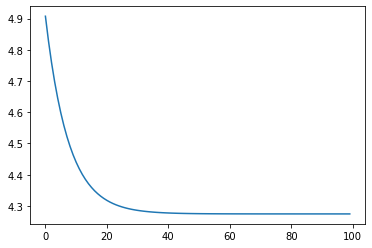

In [11]:
losses = []
slope = 0.0
N_ITER = 100
for i in range(N_ITER):
    loss = linreg_mse(slope)
    gradient = (linreg_mse(slope + eps) - linreg_mse(slope)) / eps
    slope -= .1 * gradient
    #print(f"slope = {slope:.3f}, Loss = {loss:.3f}, gradient = {gradient}")
    losses.append(loss)
plt.plot(losses)

In [12]:
slope

tensor(1.3945)

## Exact gradient

get a batch of data:

In [13]:
indices = torch.randperm(len(x))
n = 5
xx = x[indices[:n]]
yy = y_true[indices[:n]]

In [14]:
slope = 0.0
bias = 0.0

In [15]:
y_pred = slope * xx + bias
e = yy - y_pred
ae = e.abs()     ; ae = e.pow(2)
sae = ae.sum()
mae = sae / n
mae

tensor(26.8944)

In [16]:
dE_dE = 1.0          # 1 change in err gives 1 change in err
dE_dE

1.0

In [17]:
dE_dsae = 1 / n            # constant multiple rule
dE_dsae = dE_dE * dE_dsae  # 1 change in sae gives 1/n change in err
dE_dsae

0.2

In [18]:
dsae_dae = torch.ones(n)    # a sum is equally sensitive to each each element
dE_dae = dE_dsae * dsae_dae # 1 change in each of the absolute errs gives this change in mae
dE_dae

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [19]:
dae_de = e.sign()  ;   dae_de = 2 * e
dE_de = dE_dae * dae_de
dE_de

tensor([ 1.5839, -4.1312,  0.0598,  1.3297,  0.4102])

In [20]:
dE_dypred = dE_de * -1
dE_dypred

tensor([-1.5839,  4.1312, -0.0598, -1.3297, -0.4102])

In [21]:
dE_dbias = dE_dypred.sum()
dE_dbias

tensor(0.7477)

In [22]:
lr = 0.1
bias -= lr * dE_dbias

## PyTorch autograd

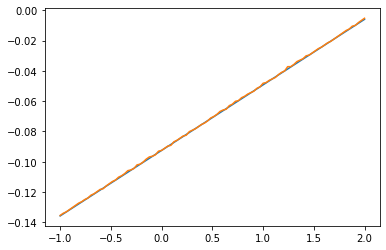

In [23]:
eps = 1e-3
gradients = []
grads_finite_diff = []
for slope in torch.linspace(1.3, 1.5, steps=100):
    slope = torch.tensor(slope.item(), requires_grad=True)
    loss = linreg_mse(slope)
    loss.backward()
    gradients.append(slope.grad.item())
    grads_finite_diff.append(
        (linreg_mse(slope.item() + eps) 
         -
         linreg_mse(slope.item()))
        / (eps))
plt.plot(slopes, gradients)
plt.plot(slopes, grads_finite_diff)

## Our grad

tensor(0.0024, requires_grad=True) tensor(0.0030, requires_grad=True)


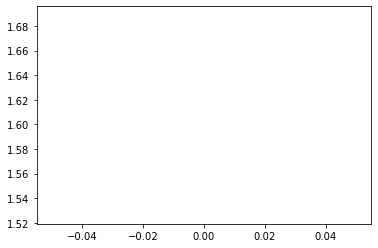

In [44]:
class MSELoss:
    def forward(self, y_true, y_pred):
        resid = y_true - y_pred
        result = resid.pow(2).mean()
        def back():
            y_pred.g = -2 * resid / len(y_true)
            y_pred.back()
        result.back = back
        return result

class MAELoss:
    def forward(self, y_true, y_pred):
        resid = y_true - y_pred
        result = resid.abs().mean()
        def back():
            y_pred.g = -resid.sign() / len(y_true)
            y_pred.back()
        result.back = back
        result.retain_grad()
        return result

class Linear:
    def __init__(self):
        self.w = torch.tensor(0.0, requires_grad=True)
        self.b = torch.tensor(0.0, requires_grad=True)
    
    def forward(self, x):
        result = self.w * x + self.b
        def back():
            self.w.g = result.g @ x
            self.b.g = result.g.sum()
        result.back = back
        result.retain_grad()
        return result

losses = []
linear = Linear()
loss_layer = MAELoss()
for i in range(1):
    y_pred = linear.forward(x)
    loss = loss_layer.forward(y_true, y_pred)
    losses.append(loss.item())
    loss.back(); loss.backward()
    linear.b.data -= linear.b.g * 0.01
    linear.w.data -= linear.w.g * 0.01
plt.plot(losses)
print(linear.w, linear.b)

In [45]:
y_pred.grad, y_pred.g

(tensor([ 0.0100,  0.0100,  0.0100,  0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100,  0.0100,  0.0100,  0.0100,  0.0100, -0.0100,
         -0.0100, -0.0100,  0.0100, -0.0100,  0.0100, -0.0100,  0.0100,  0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,  0.0100,
         -0.0100, -0.0100, -0.0100,  0.0100, -0.0100, -0.0100, -0.0100,  0.0100,
         -0.0100,  0.0100, -0.0100,  0.0100, -0.0100, -0.0100,  0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,  0.0100, -0.0100,  0.0100,
         -0.0100,  0.0100,  0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,  0.0100,  0.0100, -0.0100,
         -0.0100, -0.0100, -0.0100,  0.0100, -0.0100,  0.0100, -0.0100,  0.0100,
          0.0100,  0.0100,  0.0100,  0.0100, -0.0100, -0.0100,  0.0100,  0.0100,
         -0.0100, -0.0100,  

In [46]:
linear.b.g, linear.b.grad

(tensor(-0.3000, grad_fn=<SumBackward0>), tensor(-0.3000))

In [25]:
loss.back()

In [26]:
y_pred.g

tensor([ 0.2000,  0.2000,  0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
        -0.2000,  0.2000, -0.2000,  0.2000,  0.2000,  0.2000,  0.2000, -0.2000,
        -0.2000, -0.2000,  0.2000,  0.2000,  0.2000, -0.2000,  0.2000,  0.2000,
        -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,  0.2000,
        -0.2000, -0.2000, -0.2000,  0.2000, -0.2000, -0.2000, -0.2000,  0.2000,
         0.2000,  0.2000,  0.2000,  0.2000, -0.2000, -0.2000,  0.2000, -0.2000,
        -0.2000, -0.2000,  0.2000, -0.2000,  0.2000,  0.2000, -0.2000,  0.2000,
         0.2000,  0.2000,  0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
        -0.2000,  0.2000, -0.2000, -0.2000,  0.2000,  0.2000, -0.2000, -0.2000,
         0.2000,  0.2000, -0.2000,  0.2000, -0.2000, -0.2000,  0.2000, -0.2000,
        -0.2000, -0.2000, -0.2000, -0.2000,  0.2000,  0.2000,  0.2000,  0.2000,
         0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,  0.2000,
         0.2000, -0.2000,  0.2000,  0.20

In [27]:
linear.b.g

tensor(-1.4901e-08)

In [28]:
linear.b -= linear.b.g * 0.01